In [1]:
#Import Packages
#!pip install pandas=='1.5.3'
import pandas as pd
#!pip install seaborn
import seaborn as sns
#!pip install numpy
import numpy as np

import time
import sys
import matplotlib.pyplot as plt
import math
import os

#!pip install -U scikit-learn
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget https://datadryad.org/stash/downloads/file_stream/2572152 -O 23_09_CODEX_HuBMAP_alldata_Dryad_merged.csv
# df = pd.read_csv('23_09_CODEX_HuBMAP_alldata_Dryad_merged.csv', index_col=0)
# df

In [4]:
# Let's read in the HuBMAP dataset (From Hickey et al Nature 2023)
data_path = '/content/drive/MyDrive/Duke/Projects/PanOrgan/datasets/2023_Hickey_Nature/05_25_HuBMAP_tunit.csv'
df = pd.read_csv(data_path, index_col=0)
df.columns

<ipython-input-4-5e089e3788cd>:3: DtypeWarning: Columns (62,63,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, index_col=0)


Index(['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15', 'CHGA',
       'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR', 'CD8', 'CD11c',
       'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38', 'CD90', 'aSMA', 'CD21',
       'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68', 'CD34', 'aDef5', 'CD7',
       'CD36', 'CD138', 'CD45RO', 'Cytokeratin', 'CD117', 'CD19', 'Podoplanin',
       'CD45', 'CD56', 'CD69', 'Ki67', 'CD49a', 'CD163', 'CD161',
       'first_index', 'x', 'y', 'tissue', 'donor', 'region', 'OLFM4', 'FAP',
       'CD25', 'CollIV', 'CK7', 'Xcorr', 'Ycorr', 'unique_region',
       'neigh_name', 'neigh_sub1', 'Preservation_method', 'Tissue_location',
       'array', 'Cell Type', 'Cell Type em', 'Cell subtype', 'machine', 'MUC6',
       'Neighborhood', 'Neighborhood_Ind', 'Neigh_sub', 'NeighInd_sub',
       'Community', 'Major Community', 'Tissue Segment', 'Tissue Unit'],
      dtype='object')

In [5]:
!git clone https://github.com/johnhickey22/Hierarchical-Tissue-Unit-Annotation.git

Cloning into 'Hierarchical-Tissue-Unit-Annotation'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 54.08 KiB | 576.00 KiB/s, done.
Resolving deltas: 100% (11/11), done.


In [6]:
#Import Neighborhood Functions and Code
cellhier_path = 'Hierarchical-Tissue-Unit-Annotation/'
sys.path.append(cellhier_path)
from cellhier.general import *
from cellhier.plot_john import *
from cellhier.knn_graph_neighborhood2 import *  # Imports everything

# Set Columns to Use from Data
### The only columns of the data we will need for neighborhood analysis are the x, y coordinates of the centroids of the cell, the unique region column that is connected with each set of unique regions, and the cell type column that contains all the annotations for each cell type.

In [7]:
# Define column names that will be used for neighborhood analysis
ks = [5,10,20]  # k=5 means it collects 5 nearest neighbors for each center cell
X = 'x'                  # Variable for the X coordinate
Y = 'y'                  # Variable for the Y coordinate
reg = 'unique_region'         # Variable for the filename or region identifier associated with coordinates
cluster_col = 'Cell Type'  # Variable for cell type/subtype classification
sum_cols = list(df[cluster_col].unique())
# List of columns to keep for analysis
keep_cols = [X, Y, reg, cluster_col]

### Since the algorithm uses the index to algin computations when splitting up the data it is a good practice to reset index and save or reset index and drop

In [8]:
#Ensure unique values per region
df.reset_index(inplace=True, drop=True)

In [9]:
#Use a subset of the data for demonstration
cells = df.loc[df['donor']=='B012']
cells.reset_index(inplace=True, drop=True)
cells

,MUC2,SOX9,MUC1,CD31,Synapto,CD49f,CD15,CHGA,CDX2,ITLN1,...,machine,MUC6,Neighborhood,Neighborhood_Ind,Neigh_sub,NeighInd_sub,Community,Major Community,Tissue Segment,Tissue Unit
0,-0.221731,-0.212664,-0.184115,-0.252717,-0.274699,-0.379466,-0.215366,-0.064974,-0.233916,-0.354025,...,Sauron,-0.110648,Transit Amplifying Zone,Neuroendocrine Enriched,Epithelial,Epithelial,Secretory Epithelial,Epithelial,Mucosa,Mucosa
1,-0.221731,-0.223280,0.455716,-0.255798,-0.247580,0.314626,-0.055518,-0.109297,-0.021358,-0.271637,...,Sauron,-0.105265,Secretory Epithelial,CD8+ T Enriched IEL,Epithelial,Immune,Secretory Epithelial,Epithelial,Mucosa,Mucosa
2,-0.221731,-0.223280,0.135214,-0.255017,-0.274699,1.966520,0.123471,-0.111745,-0.243423,-0.337785,...,Sauron,-0.098045,Transit Amplifying Zone,Secretory Epithelial,Epithelial,Epithelial,Secretory Epithelial,Epithelial,Mucosa,Mucosa
3,-0.221731,-0.176880,0.117489,-0.254624,-0.273389,0.123932,-0.215366,-0.109677,-0.199404,-0.316332,...,Sauron,-0.104077,Secretory Epithelial,Secretory Epithelial,Epithelial,Epithelial,Secretory Epithelial,Epithelial,Mucosa,Mucosa
4,-0.221731,-0.163267,-0.354433,-0.256254,-0.274699,-0.288124,-0.215366,0.081588,-0.133101,-0.276248,...,Sauron,-0.107180,Adaptive Immune Enriched,CD8+ T Enriched IEL,Immune,Immune,Adaptive Immune Enriched,Immune,Mucosa,Mucosa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342856,-0.078266,-0.212861,-0.304816,-0.255793,-0.247909,-0.373370,-0.195030,-0.113153,-0.162084,-0.300476,...,Sauron,-0.098246,Stroma,Stroma,Stromal,Stromal,Stroma,Stroma,Subucosa,Muscularis externa
342857,-0.219357,-0.212348,-0.195113,-0.251927,-0.274507,-0.372440,-0.210583,-0.109014,-0.232019,-0.351118,...,Sauron,-0.095613,Innervated Stroma,Mature Epithelial,Stromal,Epithelial,Stroma,Stroma,Subucosa,Muscularis externa
342858,-0.196323,-0.201092,-0.318349,-0.252164,-0.267241,-0.367776,-0.205128,-0.110660,-0.244024,-0.285717,...,Sauron,-0.090900,Stroma,Neuroendocrine Enriched,Stromal,Epithelial,Stroma,Stroma,Subucosa,Muscularis externa
342859,-0.220256,0.429722,-0.390438,0.239971,-0.269943,-0.346409,-0.210637,0.781937,-0.129466,-0.251849,...,Sauron,-0.087865,Stroma & Innate Immune,Stroma & Innate Immune,Stromal,Stromal,Stroma,Stroma,Subucosa,Muscularis externa


# Calculate nearest neighbors for each cell

In [10]:
#Run neighborhood analysis function with radial distance threshold
Neigh = Neighborhoods(cells,ks = ks,cluster_col = cluster_col,
                      sum_cols=sum_cols,reg=reg,
                      keep_cols=keep_cols,X = X,Y=Y,add_dummies=True)
cluster_name_windows = Neigh.k_windows(distance_max=265) #Distance threshold for cell neighborhoods in terms of pixels conservative of 100 um

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:29: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.cells = pd.concat([keep,dumz],1)


Starting: 3/8 : B012_Duodenum
Finishing: 3/8 : B012_Duodenum 0.7827854156494141 0.7835018634796143
Starting: 4/8 : B012_Ileum
Finishing: 4/8 : B012_Ileum 0.3010849952697754 1.0849168300628662
Starting: 2/8 : B012_Left
Finishing: 2/8 : B012_Left 0.5182492733001709 1.6034727096557617
Starting: 5/8 : B012_Mid jejunum
Finishing: 5/8 : B012_Mid jejunum 0.45230984687805176 2.0561163425445557
Starting: 6/8 : B012_Proximal jejunum
Finishing: 6/8 : B012_Proximal jejunum 0.19275975227355957 2.249225616455078
Starting: 1/8 : B012_Right
Finishing: 1/8 : B012_Right 0.16364240646362305 2.4148294925689697
Starting: 7/8 : B012_Sigmoid
Finishing: 7/8 : B012_Sigmoid 0.339749813079834 2.754854917526245
Starting: 8/8 : B012_Trans
Finishing: 8/8 : B012_Trans 0.16621160507202148 2.923460006713867
k_dists: {5: 265, 10: 265, 20: 265} Type: <class 'dict'>
distance_max: 265 Type: <class 'int'>
B012_Duodenum:5--311/31219 cells had cells excluded.  Avg excluded=6.22508038585209
B012_Ileum:5--409/33958 cells had c

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:120: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([self.cells[self.keep_cols],window],1)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-

### Here we are creating dummy columns to store the counts of all the neighboring cell types for each individual cell and storing unique cell names.

In [11]:
# Concatenate the original 'cells' DataFrame with dummy variables created from 'cluster_col'
# pd.get_dummies() converts categorical variable(s) into dummy/indicator variables
cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)

# Get unique values from the 'cluster_col' column to use for summarization
sum_cols2 = cells[cluster_col].unique()

# Retrieve the values for these unique categories as a NumPy array
# This array can be used for further analysis or operations later for calculating the neighborhoods
values = cells[sum_cols2].values

<ipython-input-11-e704d0af7d98>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)


# Clustering the Vectors of Cell Type composition into neighborhoods
### We usually will only analyze one k value (number of neighbors) at a time

In [12]:
#Choose k value to analyze and pull out from dictionary of stored results of vectors
k = 10
windows2 = cluster_name_windows[k]
#Add cell type column to output windows dataframe
windows2[cluster_col] = cells[cluster_col]

### We will use k-means clustering to cluster the vectors that are more similar in the multidimensional space

In [13]:
#Fill in based on above for the number of clusters you want
n_neighborhoods = 20

#return a name of the column for storing the clusters
neighborhood_name = "neighborhood"+str(k)

### This is not an absolute value, but can help you to gauge where to start. I usually play around with both the number of nearest neighbors of cell types and the number of clusters. I also usually overcluster and will merge manually similar clusters (but try to limit merging).

In [14]:
# Initialize a dictionary to store the centroids for each value of 'k'
k_centroids = {}

# Initialize a MiniBatchKMeans clustering model
# 'n_clusters' is set to 'n_neighborhoods', which is the desired number of clusters
# 'random_state=0' ensures reproducibility of the results
km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

# Perform clustering on the data in 'windows2' using the columns specified in 'sum_cols'
# '.values' converts the DataFrame to a NumPy array, which is the input format for KMeans
labels = km.fit_predict(windows2[sum_cols2].values)

# Store the centroids of the clusters in the 'k_centroids' dictionary, keyed by 'k'
k_centroids[k] = km.cluster_centers_

# Add the cluster labels to the original 'cells' DataFrame
# 'neighborhood_name' is presumably a column name where these labels will be stored
cells[neighborhood_name] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Evaluate the Clustering of the Neighborhoods
### Now we need to determine whether the neighborhoods are good and if so then what to name or classify them

In [15]:
#See how many cells are contained in each cluster
sorted_grouped = cells.groupby(neighborhood_name)['x'].count().sort_values(ascending=False)
sorted_grouped

neighborhood10
2     30557
12    27354
8     26347
9     25860
16    25460
0     20798
15    19172
5     17890
19    17576
7     16922
14    14911
11    13798
17    13116
3     12337
4     12024
13    11825
6     10749
1      9713
18     9645
10     6807
Name: x, dtype: int64

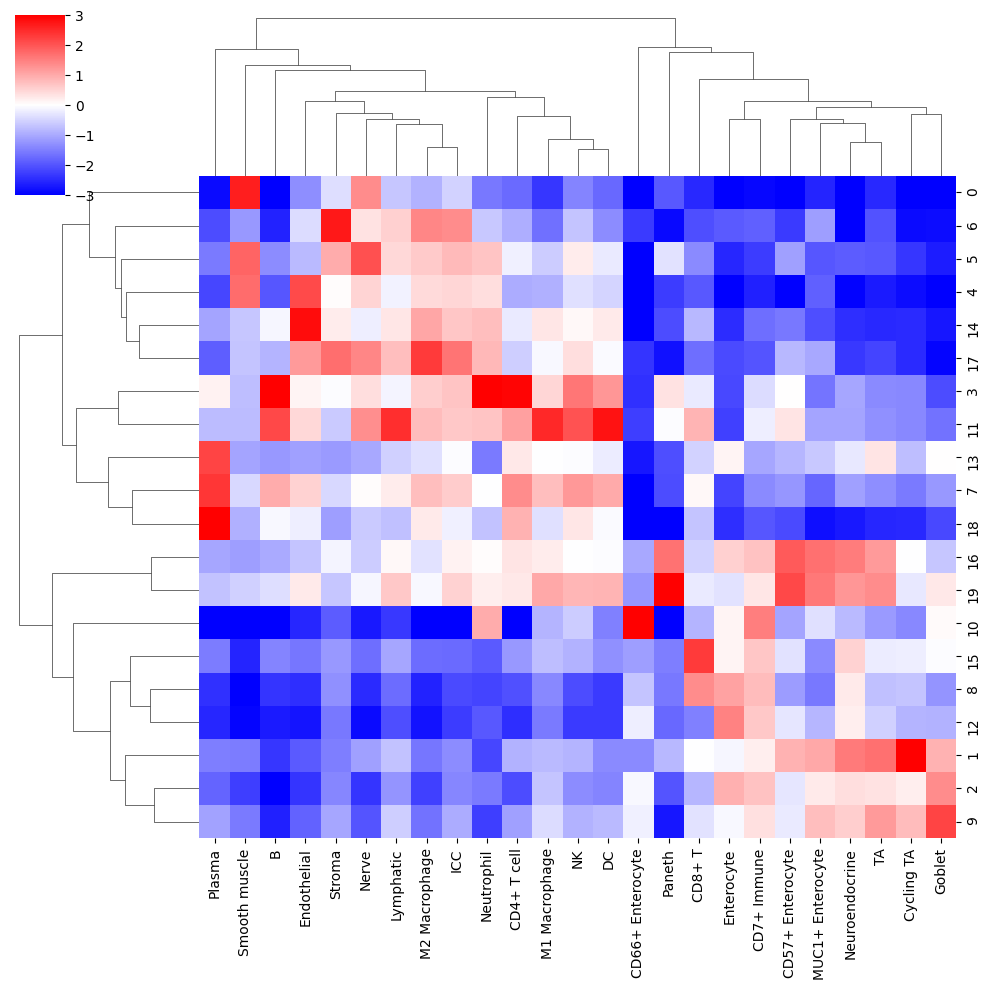

In [16]:
# Select the centroids for a specific value of 'k' for plotting
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])

# Calculate the average cell types across the 'values' array
tissue_avgs = values.mean(axis=0)

# Compute fold change (fc) of cell types abundance within a neighborhood versus that in the tissue
# This involves a log2 transformation of the ratio of (niche_clusters + tissue_avgs) to tissue_avgs
# The ratio is normalized by the sum across each row (axis=1), ensuring that the sum of ratios for each row is 1
fc = np.log2(((niche_clusters + tissue_avgs) / (niche_clusters + tissue_avgs).sum(axis=1, keepdims=True)) / tissue_avgs)

# Convert the fold change array into a pandas DataFrame for each cell type
fc = pd.DataFrame(fc, columns=sum_cols2)

# Create a clustered heatmap using seaborn's clustermap function
# 'fc' DataFrame is used as input
# vmin and vmax set the color scale limits for the heatmap (-3 to 3 in this case)
# cmap='bwr' sets the color palette to blue-white-red
# figsize=(10,10) sets the size of the heatmap
s = sns.clustermap(fc, vmin=-3, vmax=3, cmap='bwr', figsize=(10,10))

### This heatmap shows what cell types are enriched or depleted compared to random placement in the tissue and can help guide understanding of what each neighborhood represents.

### Look at a set of neighborhoods alone to get better visual locations and synergy/interaction with other neighborhoods

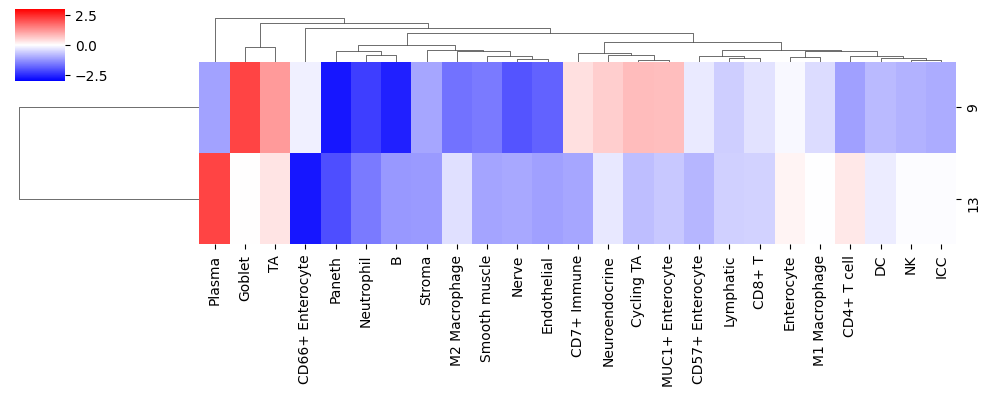

In [17]:
#Subset of clusters to investigate/plot
neigh_list = [9, 13]

#Same code as above, but just with plotting a subset of the clusters
s=sns.clustermap(fc.iloc[neigh_list,:], vmin =-3,vmax = 3,cmap = 'bwr',figsize=(10,4))

B012_Right


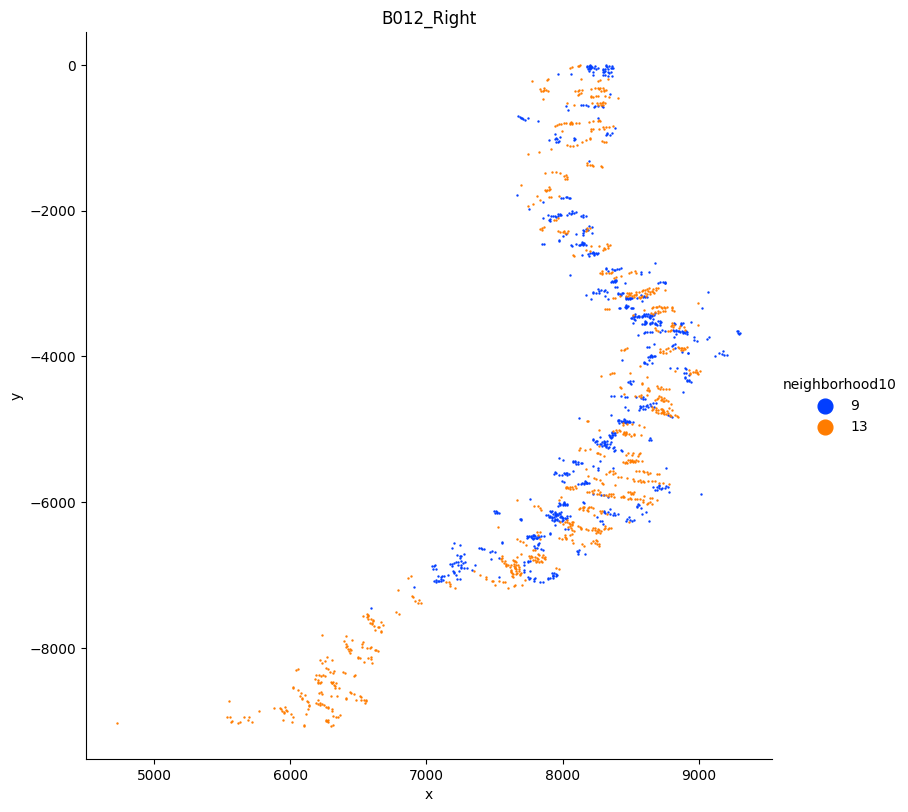

B012_Left


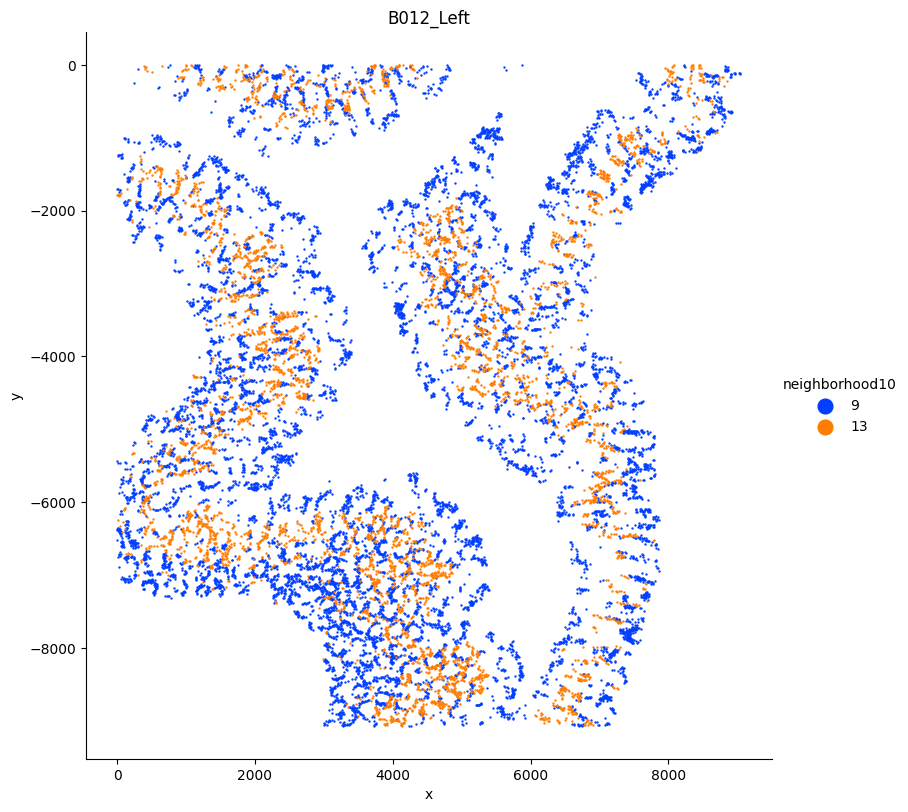

B012_Duodenum


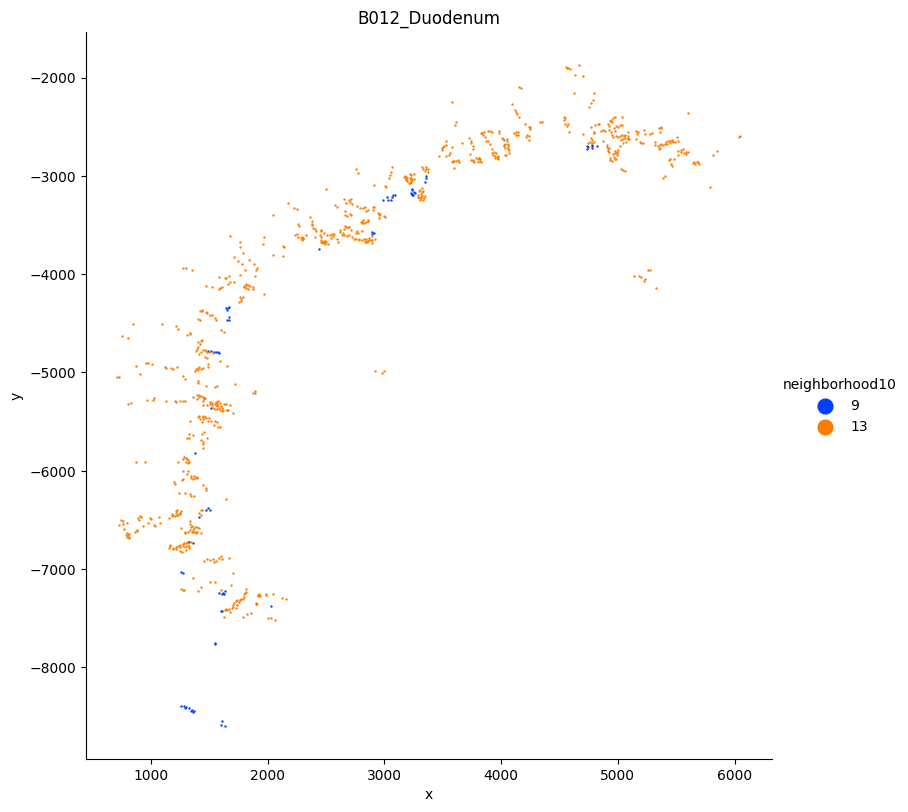

B012_Ileum


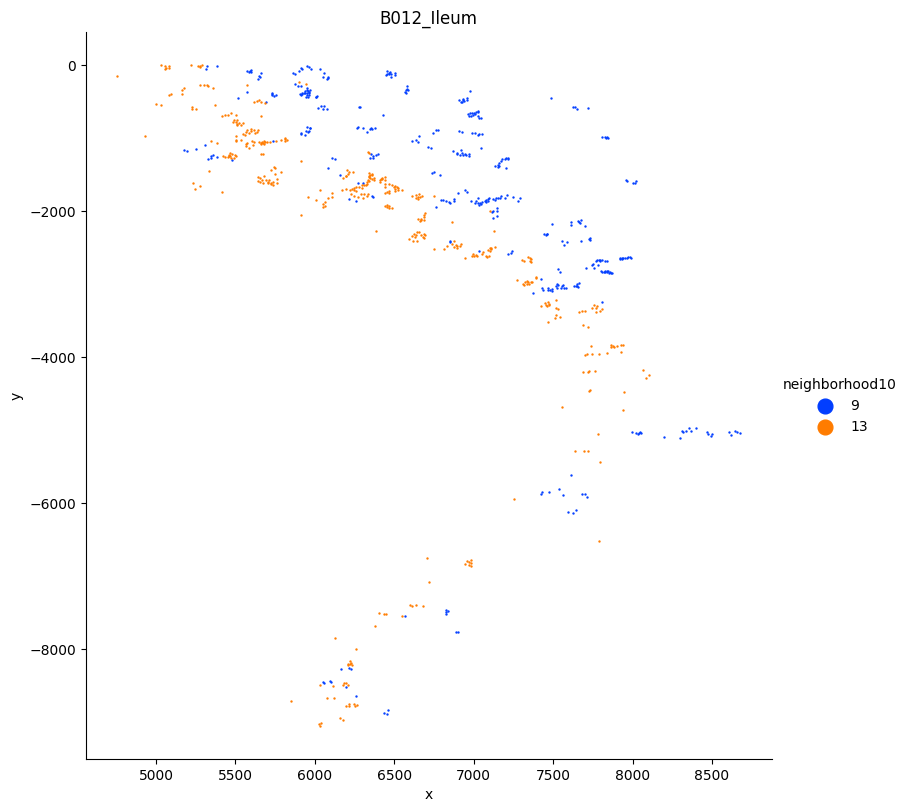

B012_Mid jejunum


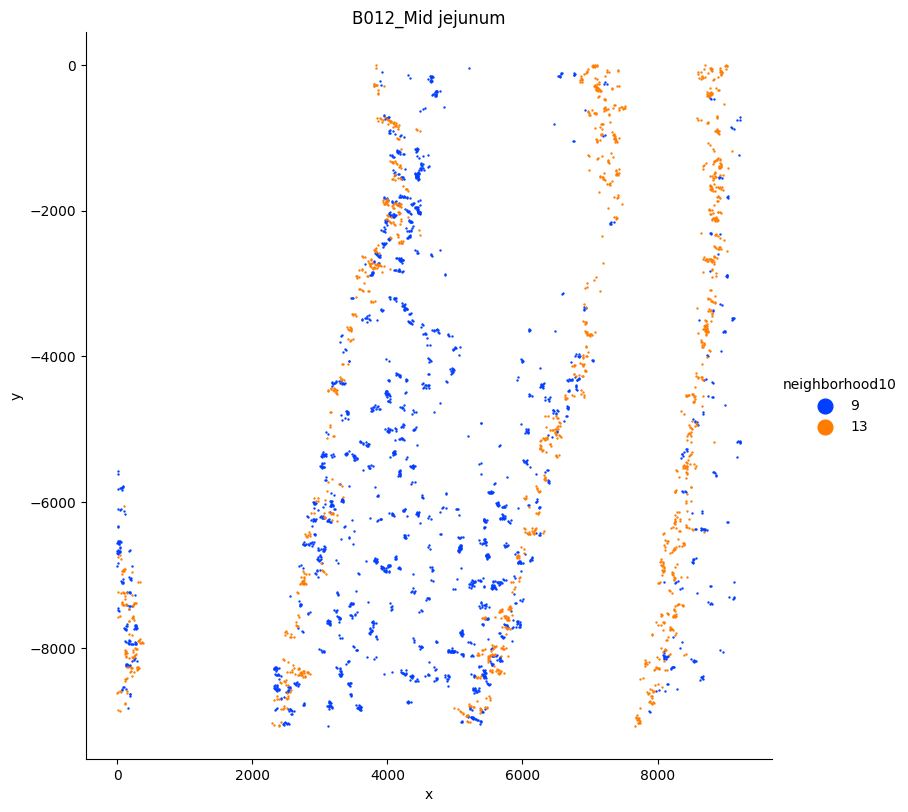

B012_Proximal jejunum


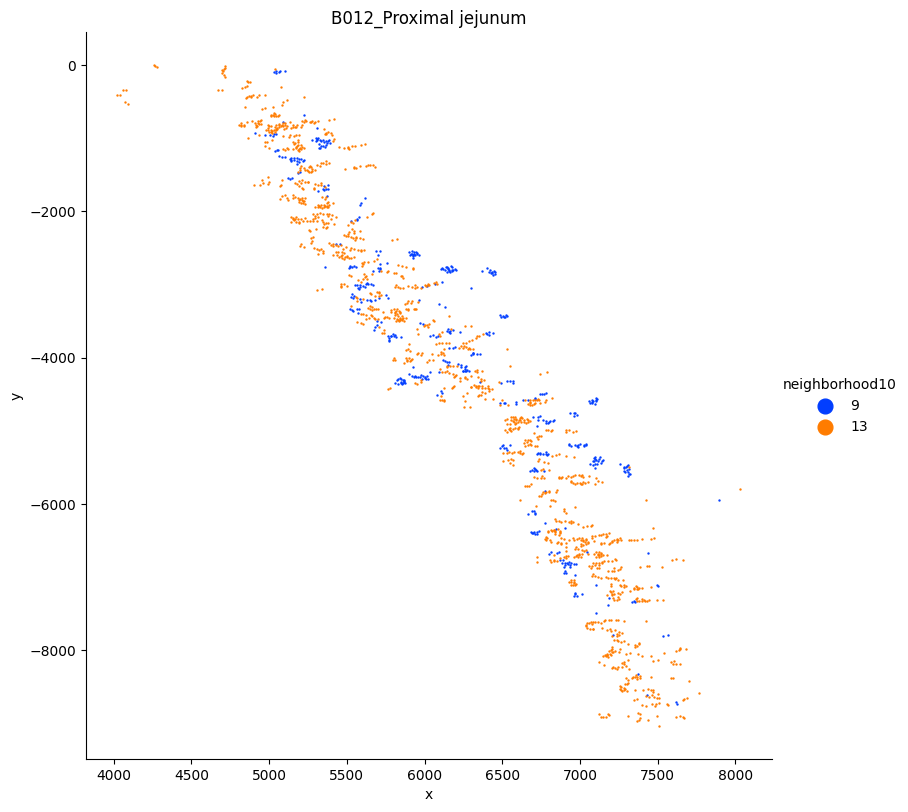

B012_Sigmoid


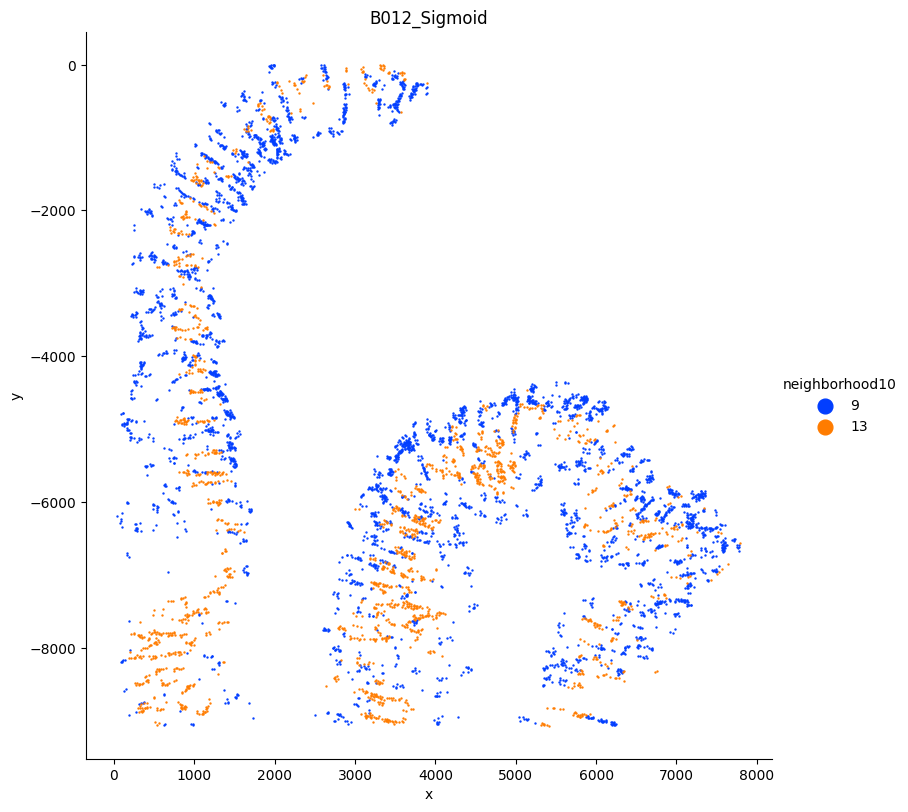

B012_Trans


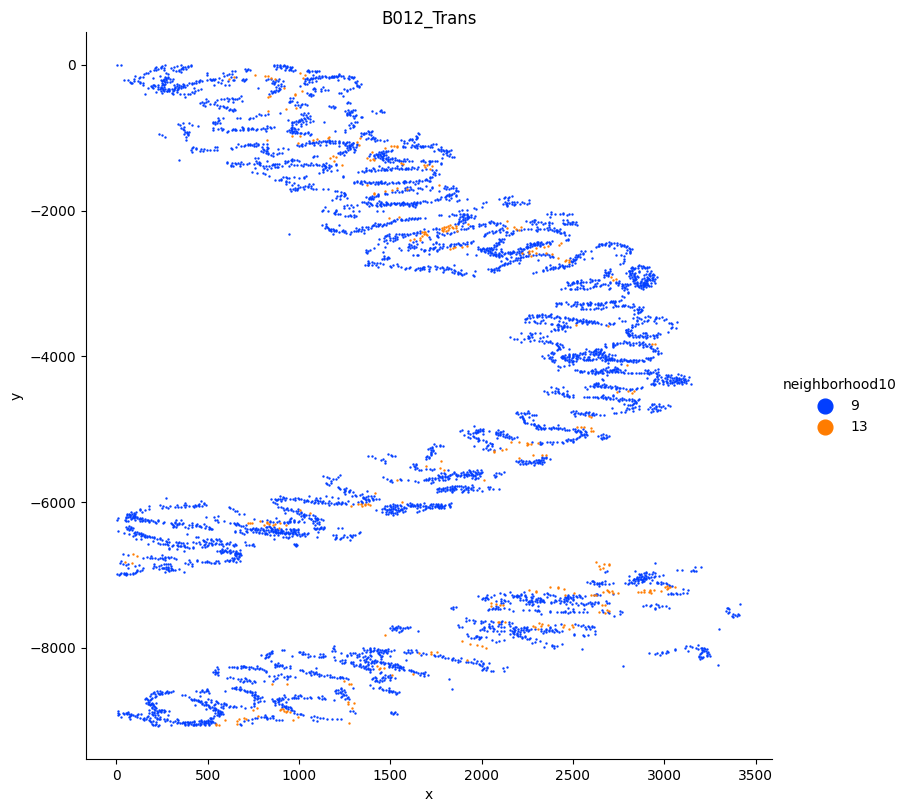

In [18]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot2(cells.loc[cells[neighborhood_name].isin(neigh_list)], X = 'x', Y='y', exp = 'unique_region',
               hue = neighborhood_name, invert_y=True, size = 2, figsize=8)

# Naming Neighborhoods
### Once you have figured out the neighborhoods identity you can give them a name for ease of interpretation in addition to the number and also for merging similar neighborhoods

### * Note: these annotations are rough annotations for the sake of this demonstration notebook and have not been extensively validated like the existing labeled Neighborhoods for this dataset that preexist.

In [19]:
n_conversion_20 = {
    0: 'Stromal',
    1: 'CD8+ T IEL',
    2: 'Neutrophil-enriched Stromal',
    3: 'Proliferating TA zone',
    4: 'Smooth Muscle',
    5: 'Mature Epithelial',
    6: 'Epithelial',
    7: 'Paneth/Glandular',
    8: 'Plasma-enriched',
    9: 'Smooth Muscle and Vasculature',

    10: 'TA zone',
    11: 'Follicle',
    12: 'CD8+ T IEL',
    13: 'Smooth Muscle and Immune',
    14: 'Epithelial',
    15: 'Stromal',
    16: 'Plasma-enriched',
    17: 'Goblet-enriched',
    18: 'Goblet-enriched',
    19: 'Vasculature and Immune',

}
cells['Neighborhood_test']=cells[neighborhood_name].map(n_conversion_20)
cells['Neighborhood_test'].unique()

array(['Plasma-enriched', 'Stromal', 'Neutrophil-enriched Stromal',
       'CD8+ T IEL', 'Follicle', 'Vasculature and Immune', 'TA zone',
       'Smooth Muscle and Immune', 'Proliferating TA zone',
       'Paneth/Glandular', 'Smooth Muscle and Vasculature',
       'Goblet-enriched', 'Epithelial', 'Mature Epithelial',
       'Smooth Muscle'], dtype=object)

In [20]:
#Create unique color palettes for cell type and neighborhood maps
color_list = [
    'blue', 'red', 'yellow', 'magenta', 'orange', 'green', 'brown', 'black',
    'gray', 'skyblue', 'gold', 'plum', 'yellowgreen', 'tan', 'navy', 'bisque',
    'goldenrod', 'blueviolet', 'darkorange', 'teal', 'olive', 'dimgray',
    'indigo', 'lightcoral', 'cyan', 'ivory', 'beige', 'darkblue', 'lightcyan',
    'royalblue'
]
cell_list = list(cells['Cell Type'].unique())
neigh_list = list(cells['Neighborhood_test'].unique())
dict_cell = dict(zip(cell_list, color_list))
dict_neigh = dict(zip(neigh_list, color_list))
dict_cell

{'Cycling TA': 'blue',
 'CD66+ Enterocyte': 'red',
 'Enterocyte': 'yellow',
 'MUC1+ Enterocyte': 'magenta',
 'Paneth': 'orange',
 'Neuroendocrine': 'green',
 'Goblet': 'brown',
 'CD57+ Enterocyte': 'black',
 'M1 Macrophage': 'gray',
 'Stroma': 'skyblue',
 'Smooth muscle': 'gold',
 'CD4+ T cell': 'plum',
 'Plasma': 'yellowgreen',
 'M2 Macrophage': 'tan',
 'NK': 'navy',
 'DC': 'bisque',
 'Lymphatic': 'goldenrod',
 'Nerve': 'blueviolet',
 'ICC': 'darkorange',
 'CD8+ T': 'teal',
 'Endothelial': 'olive',
 'Neutrophil': 'dimgray',
 'TA': 'indigo',
 'B': 'lightcoral',
 'CD7+ Immune': 'cyan'}

In [21]:
figs_neigh = catplot2(df = cells, hue = 'Neighborhood_test', exp='unique_region', X='x', Y='y',
        invert_y=True, size=1, legend=True, palette=dict_neigh, figsize=8, exps=None, axis='on', scatter_kws={})

Output hidden; open in https://colab.research.google.com to view.

In [22]:
figs_cell = catplot2(df = cells, hue = 'Cell Type', exp='unique_region', X='x', Y='y',
        invert_y=True, size=1, style='white', legend=True, palette=dict_cell, figsize=8, exps=None, axis='on', scatter_kws={})

Output hidden; open in https://colab.research.google.com to view.

In [23]:
for idx, fig in enumerate(figs_cell):
    # Set a unique name for each plot
    filename = f"cell_plot_{idx}.png"

    # Save the plot with the unique filename
    fig.savefig(filename, format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
for idx, fig in enumerate(figs_neigh):
    # Set a unique name for each plot
    filename = f"neigh_plot_{idx}.png"

    # Save the plot with the unique filename
    fig.savefig(filename, format='png', dpi=300, transparent=True, bbox_inches='tight')

# Calculate Communities from Neighborhood Labels

### We will follow the same code for the above Neighborhood calculations, except we will use the "Neighborhood" labels for the calculations and will look at much bigger window sizes

In [24]:
# Define column names that will be used for neighborhood analysis
ks = [50,75,100]  # k=5 means it collects 5 nearest neighbors for each center cell
X = 'x'                  # Variable for the X coordinate
Y = 'y'                  # Variable for the Y coordinate
reg = 'unique_region'         # Variable for the filename or region identifier associated with coordinates
cluster_col = 'Neighborhood_test'  # Variable for cell type/subtype classification
sum_cols = list(cells[cluster_col].unique())
# List of columns to keep for analysis
keep_cols = [X, Y, reg, cluster_col]

#Run neighborhood analysis function with radial distance threshold
Neigh = Neighborhoods(cells,ks = ks,cluster_col = cluster_col,
                      sum_cols=sum_cols,reg=reg,
                      keep_cols=keep_cols,X = X,Y=Y,add_dummies=True)
cluster_name_windows = Neigh.k_windows(distance_max=1000) #Distance threshold for cell neighborhoods in terms of pixels conservative of 100 um

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:29: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.cells = pd.concat([keep,dumz],1)


Starting: 3/8 : B012_Duodenum
Finishing: 3/8 : B012_Duodenum 0.6710572242736816 0.671550989151001
Starting: 4/8 : B012_Ileum
Finishing: 4/8 : B012_Ileum 0.6848983764648438 1.3567569255828857
Starting: 2/8 : B012_Left
Finishing: 2/8 : B012_Left 1.7151482105255127 3.0722010135650635
Starting: 5/8 : B012_Mid jejunum
Finishing: 5/8 : B012_Mid jejunum 1.5366418361663818 4.609795808792114
Starting: 6/8 : B012_Proximal jejunum
Finishing: 6/8 : B012_Proximal jejunum 0.6796772480010986 5.290405750274658
Starting: 1/8 : B012_Right
Finishing: 1/8 : B012_Right 0.5220217704772949 5.813687801361084
Starting: 7/8 : B012_Sigmoid
Finishing: 7/8 : B012_Sigmoid 1.3758141994476318 7.189788103103638
Starting: 8/8 : B012_Trans
Finishing: 8/8 : B012_Trans 0.797027587890625 7.990772008895874
k_dists: {50: 1000, 75: 1000, 100: 1000} Type: <class 'dict'>
distance_max: 1000 Type: <class 'int'>
B012_Duodenum:50--0/31219 cells had cells excluded.  Avg excluded=0
B012_Ileum:50--0/33958 cells had cells excluded.  Av

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:120: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([self.cells[self.keep_cols],window],1)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-

<ipython-input-25-bb42d3c933fb>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


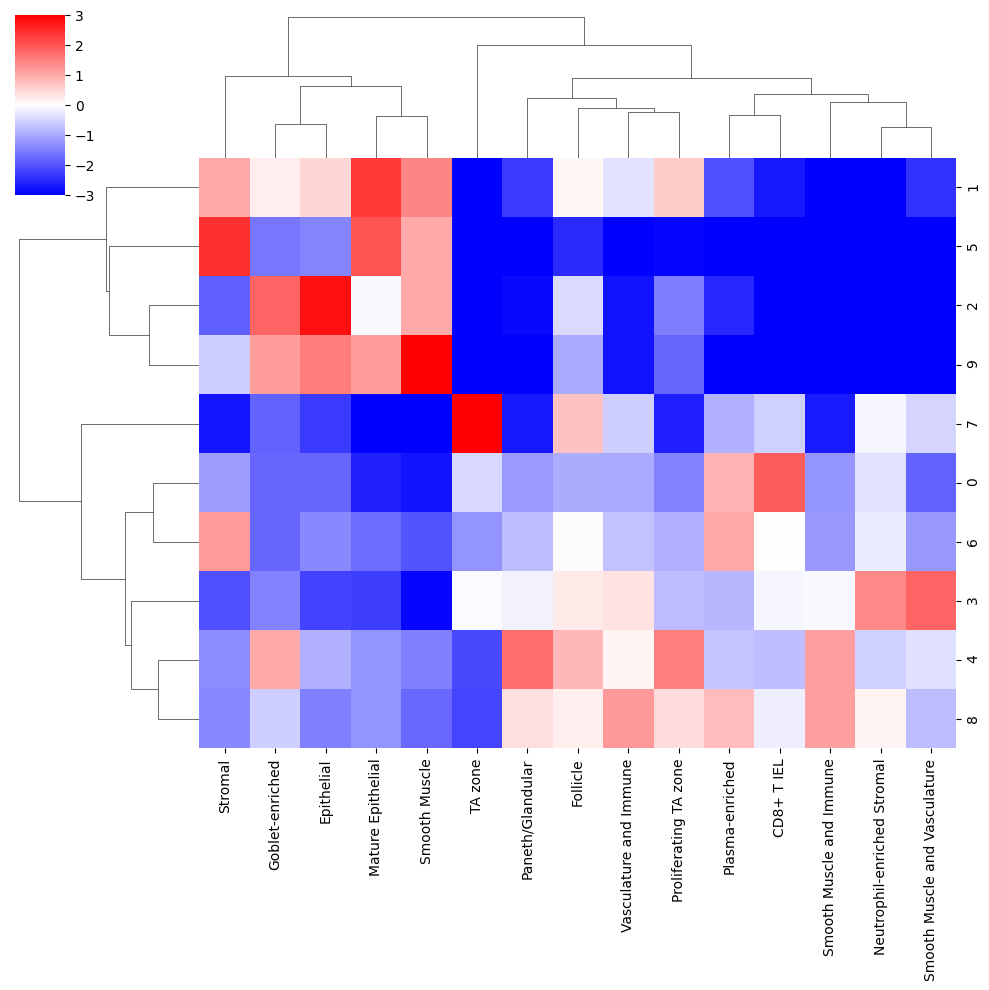

In [25]:
# Concatenate the original 'cells' DataFrame with dummy variables created from 'cluster_col'
# pd.get_dummies() converts categorical variable(s) into dummy/indicator variables
cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)

# Get unique values from the 'cluster_col' column to use for summarization
sum_cols2 = cells[cluster_col].unique()

# Retrieve the values for these unique categories as a NumPy array
# This array can be used for further analysis or operations later for calculating the neighborhoods
values = cells[sum_cols2].values

#Choose k value to analyze and pull out from dictionary of stored results of vectors
k = 100
windows2 = cluster_name_windows[k]
#Add cell type column to output windows dataframe
windows2[cluster_col] = cells[cluster_col]

#Fill in based on above for the number of clusters you want
n_neighborhoods = 10

#return a name of the column for storing the clusters
neighborhood_name = "neighborhood"+str(k)

# Initialize a dictionary to store the centroids for each value of 'k'
k_centroids = {}

# Initialize a MiniBatchKMeans clustering model
# 'n_clusters' is set to 'n_neighborhoods', which is the desired number of clusters
# 'random_state=0' ensures reproducibility of the results
km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

# Perform clustering on the data in 'windows2' using the columns specified in 'sum_cols'
# '.values' converts the DataFrame to a NumPy array, which is the input format for KMeans
labels = km.fit_predict(windows2[sum_cols2].values)

# Store the centroids of the clusters in the 'k_centroids' dictionary, keyed by 'k'
k_centroids[k] = km.cluster_centers_

# Add the cluster labels to the original 'cells' DataFrame
# 'neighborhood_name' is presumably a column name where these labels will be stored
cells[neighborhood_name] = labels

# Select the centroids for a specific value of 'k' for plotting
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])

# Calculate the average cell types across the 'values' array
tissue_avgs = values.mean(axis=0)

# Compute fold change (fc) of cell types abundance within a neighborhood versus that in the tissue
# This involves a log2 transformation of the ratio of (niche_clusters + tissue_avgs) to tissue_avgs
# The ratio is normalized by the sum across each row (axis=1), ensuring that the sum of ratios for each row is 1
fc = np.log2(((niche_clusters + tissue_avgs) / (niche_clusters + tissue_avgs).sum(axis=1, keepdims=True)) / tissue_avgs)

# Convert the fold change array into a pandas DataFrame for each cell type
fc = pd.DataFrame(fc, columns=sum_cols2)

# Create a clustered heatmap using seaborn's clustermap function
# 'fc' DataFrame is used as input
# vmin and vmax set the color scale limits for the heatmap (-3 to 3 in this case)
# cmap='bwr' sets the color palette to blue-white-red
# figsize=(10,10) sets the size of the heatmap
s = sns.clustermap(fc, vmin=-3, vmax=3, cmap='bwr', figsize=(10,10))

B012_Right


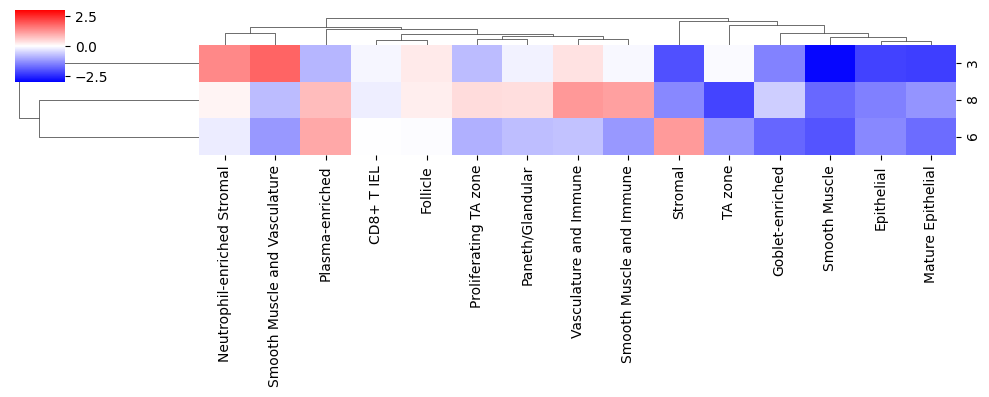

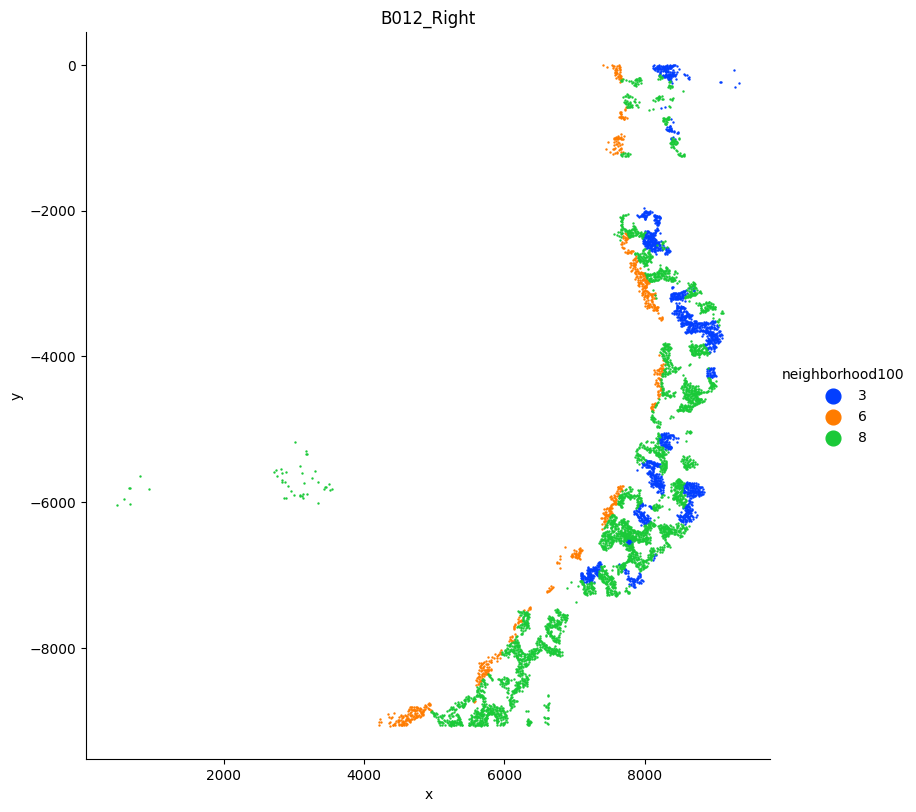

B012_Left


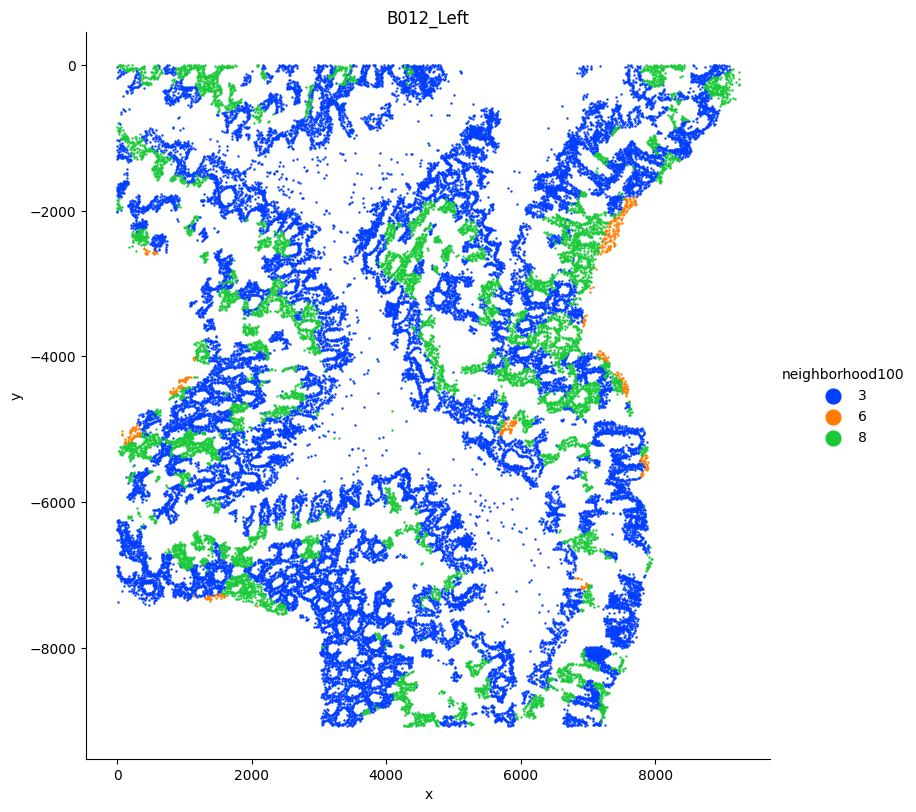

B012_Duodenum


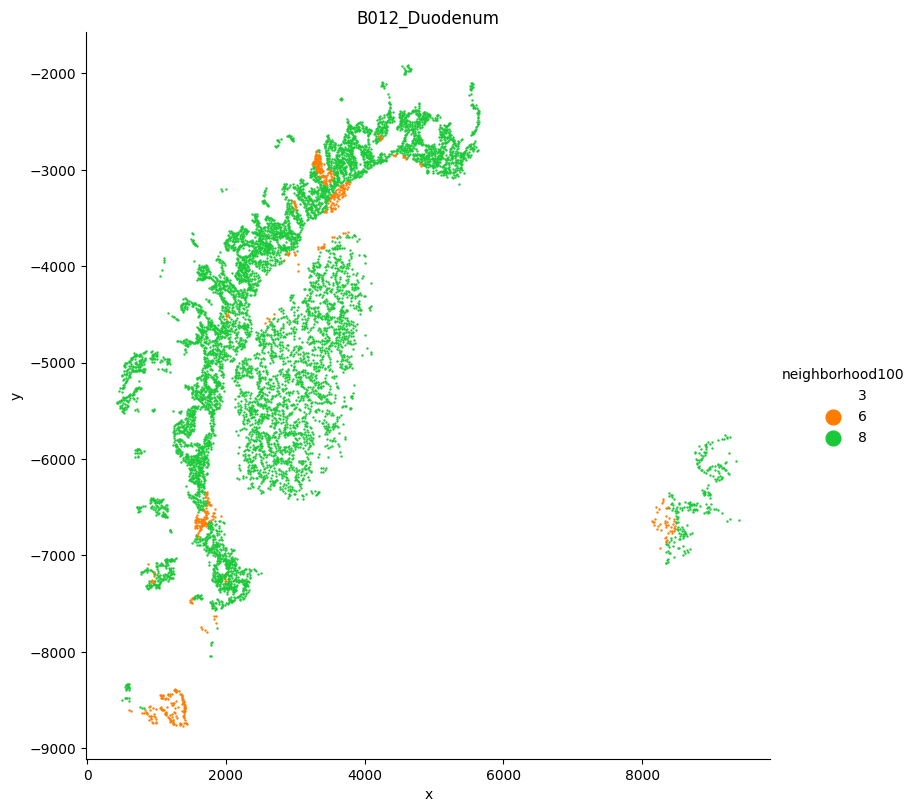

B012_Ileum


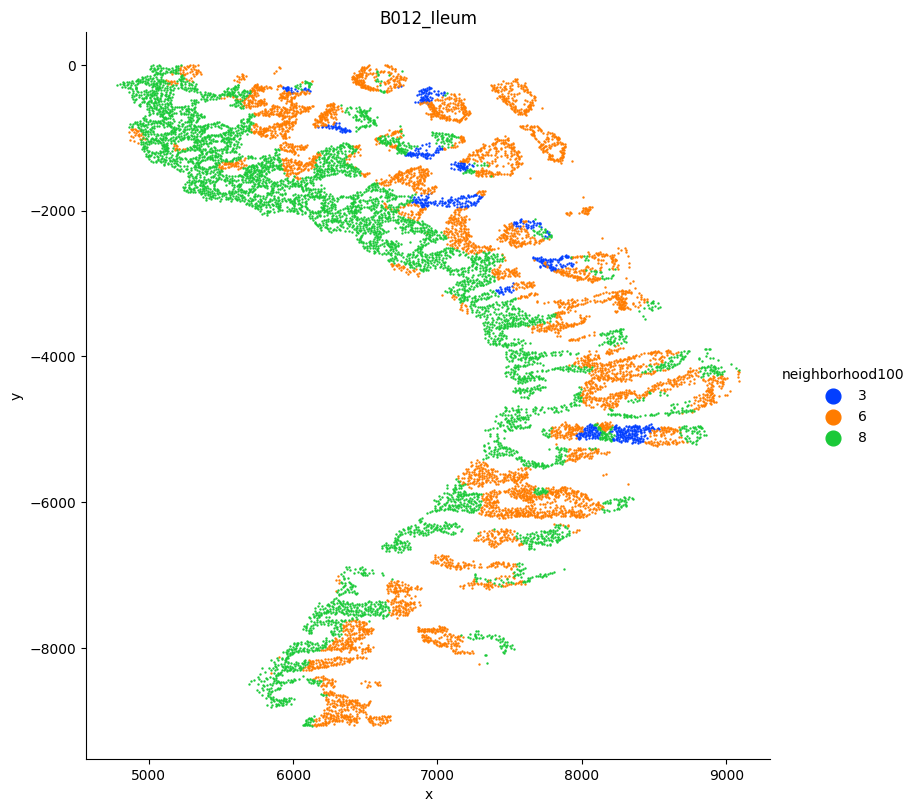

B012_Mid jejunum


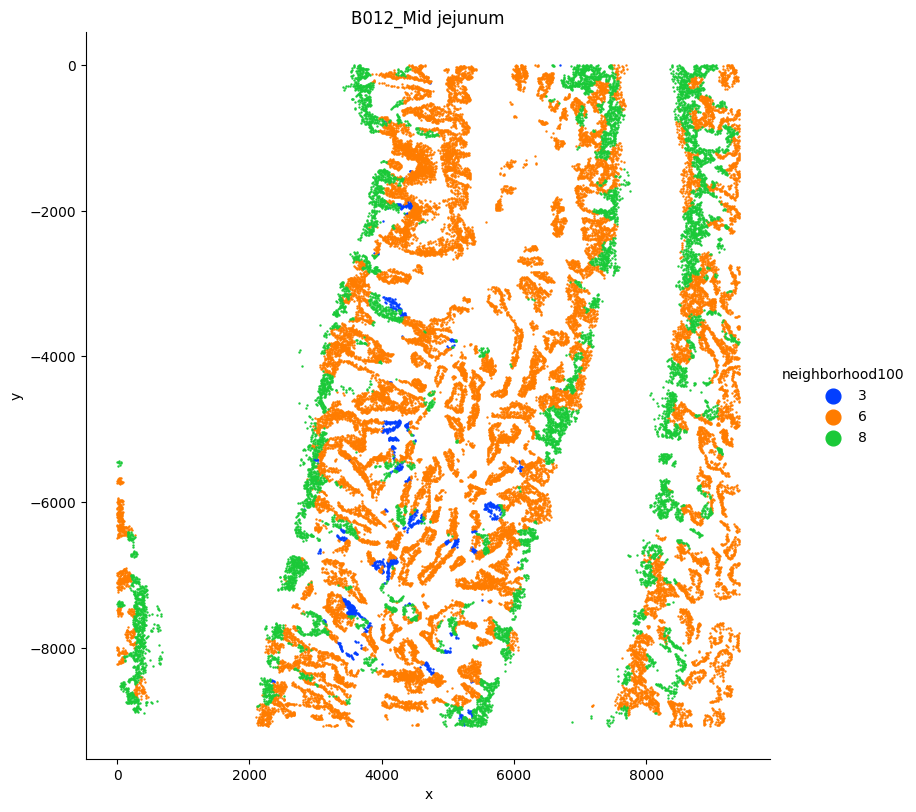

B012_Proximal jejunum


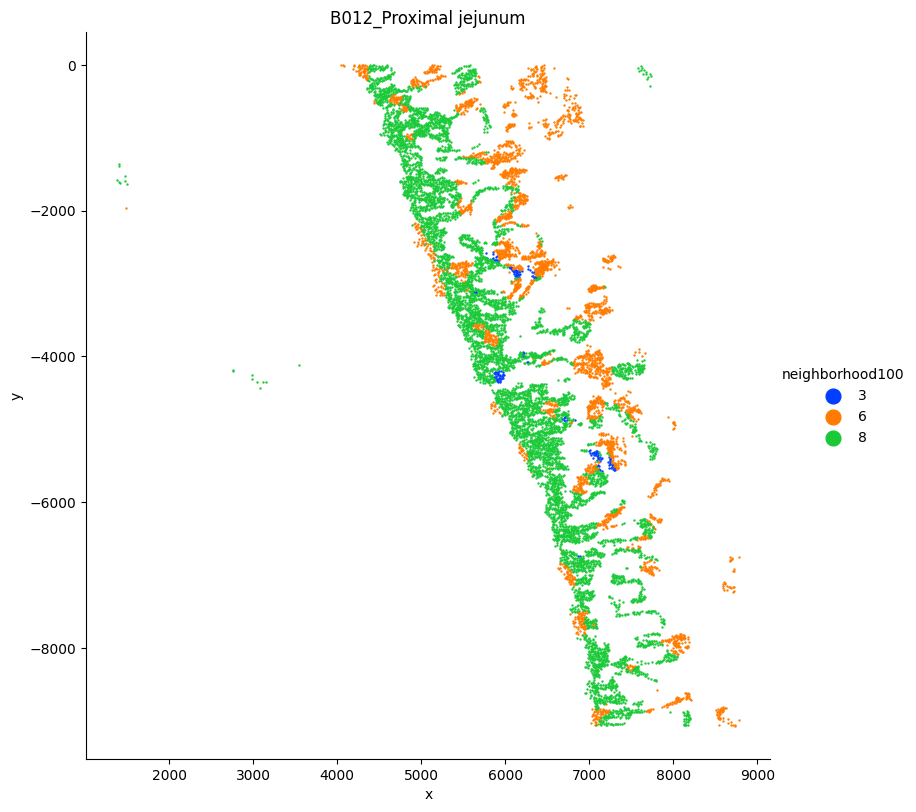

B012_Sigmoid


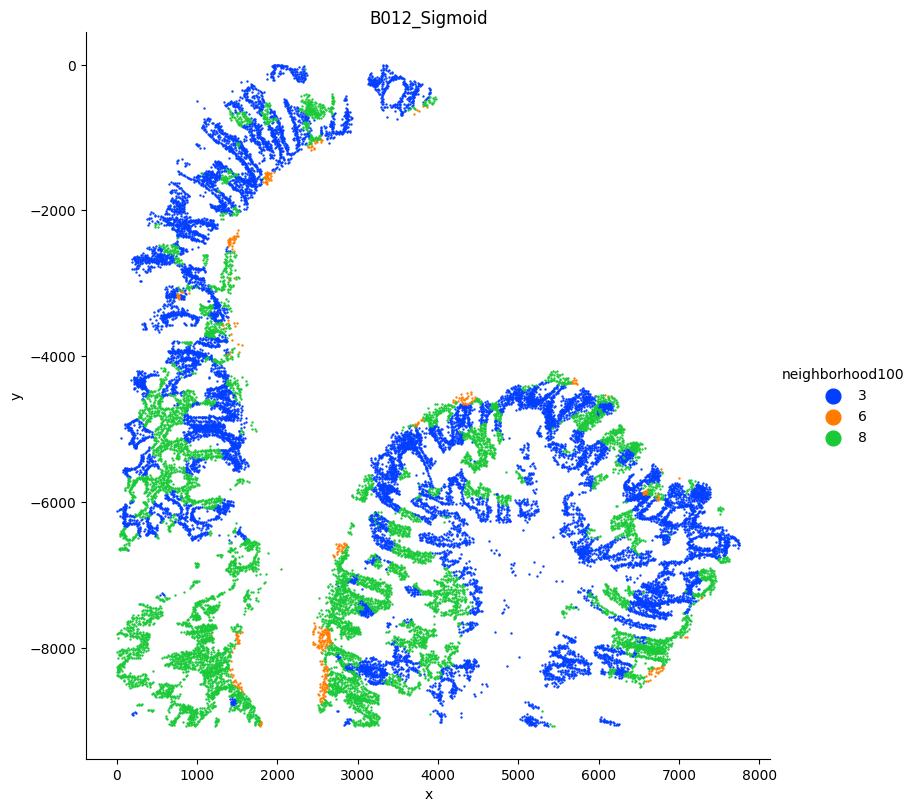

B012_Trans


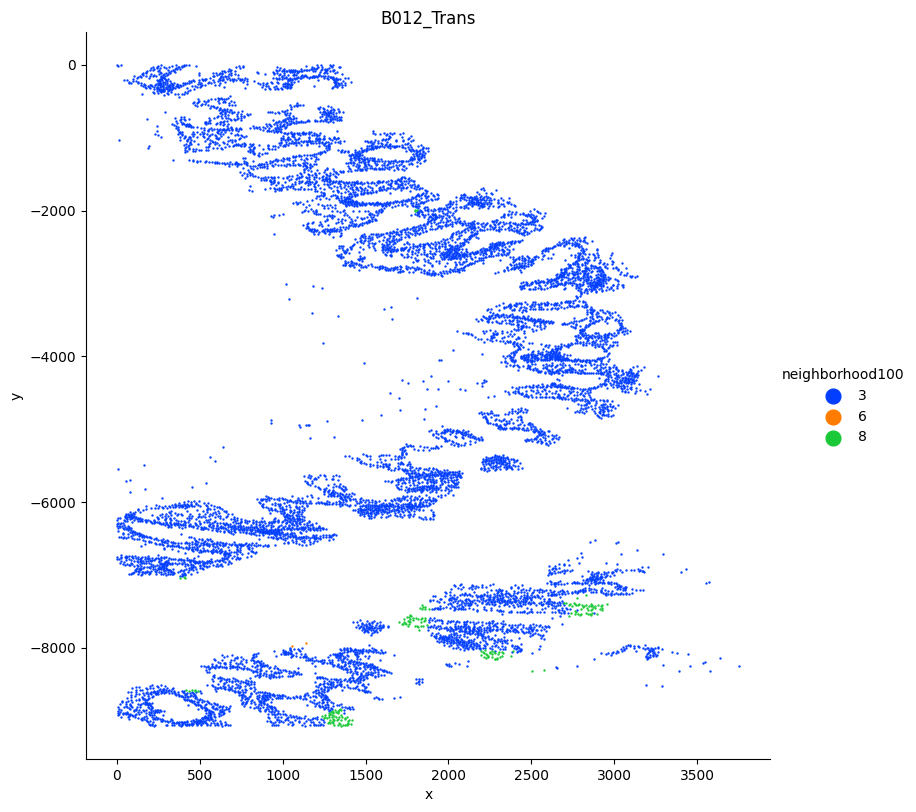

In [26]:
#Subset of clusters to investigate/plot
neigh_list = [8,3,6]

#Same code as above, but just with plotting a subset of the clusters
s=sns.clustermap(fc.iloc[neigh_list,:], vmin =-3,vmax = 3,cmap = 'bwr',figsize=(10,4))

#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot2(cells.loc[cells[neighborhood_name].isin(neigh_list)], X = 'x', Y='y', exp = 'unique_region',
               hue = neighborhood_name, invert_y=True, size = 2, figsize=8)

In [27]:
n_conversion_10 = {
    0: 'Stromal area',
    1: 'Paneth & Glandular area',
    2: 'Muscle area',
    3: 'Goblet-enriched area',
    4: 'Plasma-enriched area',
    5: 'Stromal Area',
    6: 'Mature Epithelial area',
    7: 'Proliferating TA area',
    8: 'CD8+ T IEL area',
    9: 'Muscle area',

}
cells['Community_test']=cells[neighborhood_name].map(n_conversion_10)
comm_list = list(cells['Community_test'].unique())
dict_comm = dict(zip(comm_list, color_list))
dict_comm

{'Stromal area': 'blue',
 'CD8+ T IEL area': 'red',
 'Plasma-enriched area': 'yellow',
 'Goblet-enriched area': 'magenta',
 'Proliferating TA area': 'orange',
 'Paneth & Glandular area': 'green',
 'Mature Epithelial area': 'brown',
 'Muscle area': 'black',
 'Stromal Area': 'gray'}

In [28]:
catplot2(df = cells, hue = 'Community_test', exp='unique_region', X='x', Y='y',
        invert_y=False, size=1, legend=True, palette=dict_comm, figsize=8,
        style='white', exps=None, axis='on', scatter_kws={})

Output hidden; open in https://colab.research.google.com to view.

In [29]:
# Define column names that will be used for neighborhood analysis
ks = [200,300]  # k=5 means it collects 5 nearest neighbors for each center cell
X = 'x'                  # Variable for the X coordinate
Y = 'y'                  # Variable for the Y coordinate
reg = 'unique_region'         # Variable for the filename or region identifier associated with coordinates
cluster_col = 'Community_test'  # Variable for cell type/subtype classification
sum_cols = list(cells[cluster_col].unique())
# List of columns to keep for analysis
keep_cols = [X, Y, reg, cluster_col]

#Run neighborhood analysis function with radial distance threshold
Neigh = Neighborhoods(cells,ks = ks,cluster_col = cluster_col,
                      sum_cols=sum_cols,reg=reg,
                      keep_cols=keep_cols,X = X,Y=Y,add_dummies=True)
cluster_name_windows = Neigh.k_windows(distance_max=3000) #Distance threshold for cell neighborhoods in terms of pixels conservative of 100 um

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:29: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.cells = pd.concat([keep,dumz],1)


Starting: 3/8 : B012_Duodenum
Finishing: 3/8 : B012_Duodenum 1.9671881198883057 1.9680285453796387
Starting: 4/8 : B012_Ileum
Finishing: 4/8 : B012_Ileum 2.6472160816192627 4.61775016784668
Starting: 2/8 : B012_Left
Finishing: 2/8 : B012_Left 12.891541004180908 17.516809701919556
Starting: 5/8 : B012_Mid jejunum
Finishing: 5/8 : B012_Mid jejunum 5.0322747230529785 22.553694248199463
Starting: 6/8 : B012_Proximal jejunum
Finishing: 6/8 : B012_Proximal jejunum 2.3388938903808594 24.898305892944336
Starting: 1/8 : B012_Right
Finishing: 1/8 : B012_Right 2.388554096221924 27.289143562316895
Starting: 7/8 : B012_Sigmoid
Finishing: 7/8 : B012_Sigmoid 4.063557863235474 31.357351303100586
Starting: 8/8 : B012_Trans
Finishing: 8/8 : B012_Trans 1.9154257774353027 33.275237798690796
k_dists: {200: 3000, 300: 3000} Type: <class 'dict'>
distance_max: 3000 Type: <class 'int'>
B012_Duodenum:200--0/31219 cells had cells excluded.  Avg excluded=0
B012_Ileum:200--0/33958 cells had cells excluded.  Avg ex

/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:120: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([self.cells[self.keep_cols],window],1)
/content/Hierarchical-Tissue-Unit-Annotation/cellhier/knn_graph_neighborhood2.py:118: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = self.sum_cols) for exp in self.exps],0)
/content/Hierarchical-

<ipython-input-30-ea2145873b45>:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


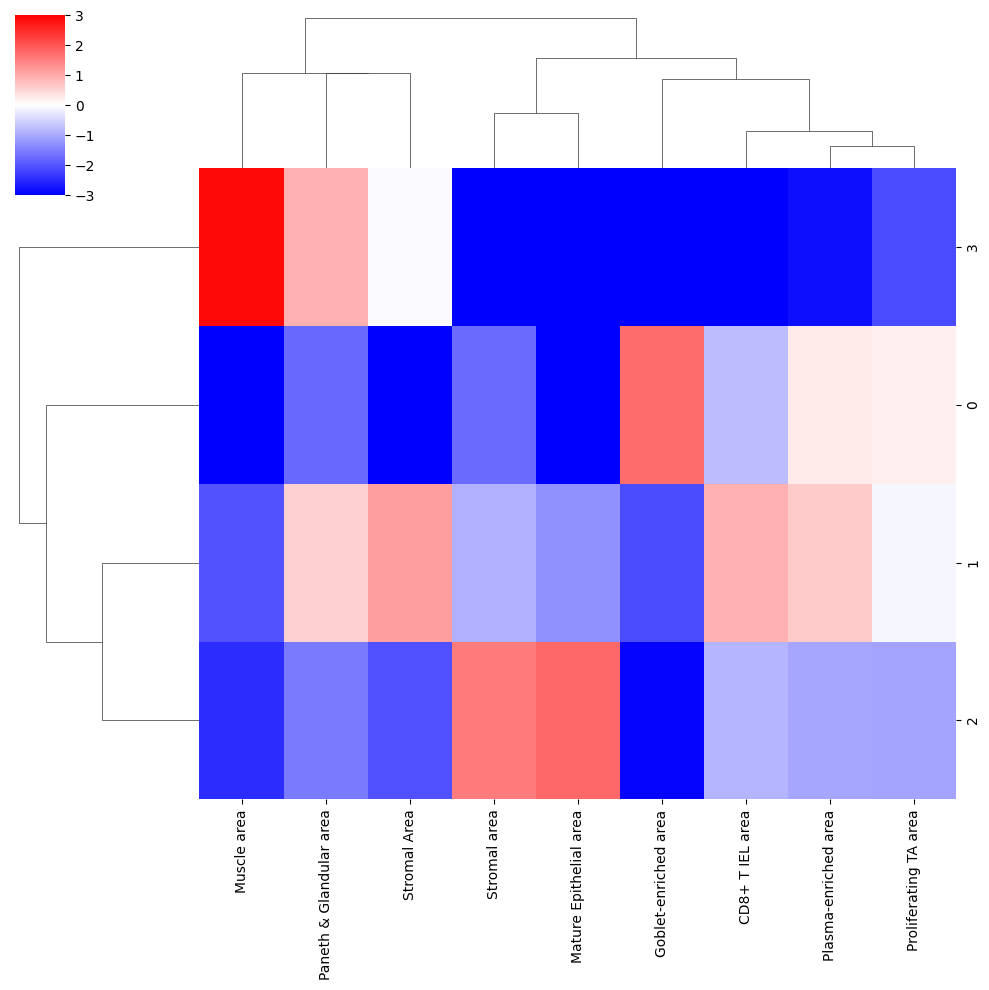

In [30]:
# Concatenate the original 'cells' DataFrame with dummy variables created from 'cluster_col'
# pd.get_dummies() converts categorical variable(s) into dummy/indicator variables
cells = pd.concat([cells, pd.get_dummies(cells[cluster_col])], 1)

# Get unique values from the 'cluster_col' column to use for summarization
sum_cols2 = cells[cluster_col].unique()

# Retrieve the values for these unique categories as a NumPy array
# This array can be used for further analysis or operations later for calculating the neighborhoods
values = cells[sum_cols2].values

#Choose k value to analyze and pull out from dictionary of stored results of vectors
k = 300
windows2 = cluster_name_windows[k]

#Add cell type column to output windows dataframe
windows2[cluster_col] = cells[cluster_col]

#Fill in based on above for the number of clusters you want
n_neighborhoods = 4

#return a name of the column for storing the clusters
neighborhood_name = "neighborhood"+str(k)

# Initialize a dictionary to store the centroids for each value of 'k'
k_centroids = {}

# Initialize a MiniBatchKMeans clustering model
# 'n_clusters' is set to 'n_neighborhoods', which is the desired number of clusters
# 'random_state=0' ensures reproducibility of the results
km = MiniBatchKMeans(n_clusters=n_neighborhoods, random_state=0)

# Perform clustering on the data in 'windows2' using the columns specified in 'sum_cols'
# '.values' converts the DataFrame to a NumPy array, which is the input format for KMeans
labels = km.fit_predict(windows2[sum_cols2].values)

# Store the centroids of the clusters in the 'k_centroids' dictionary, keyed by 'k'
k_centroids[k] = km.cluster_centers_

# Add the cluster labels to the original 'cells' DataFrame
# 'neighborhood_name' is presumably a column name where these labels will be stored
cells[neighborhood_name] = labels

# Select the centroids for a specific value of 'k' for plotting
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])

# Calculate the average cell types across the 'values' array
tissue_avgs = values.mean(axis=0)

# Compute fold change (fc) of cell types abundance within a neighborhood versus that in the tissue
# This involves a log2 transformation of the ratio of (niche_clusters + tissue_avgs) to tissue_avgs
# The ratio is normalized by the sum across each row (axis=1), ensuring that the sum of ratios for each row is 1
fc = np.log2(((niche_clusters + tissue_avgs) / (niche_clusters + tissue_avgs).sum(axis=1, keepdims=True)) / tissue_avgs)

# Convert the fold change array into a pandas DataFrame for each cell type
fc = pd.DataFrame(fc, columns=sum_cols2)

# Create a clustered heatmap using seaborn's clustermap function
# 'fc' DataFrame is used as input
# vmin and vmax set the color scale limits for the heatmap (-3 to 3 in this case)
# cmap='bwr' sets the color palette to blue-white-red
# figsize=(10,10) sets the size of the heatmap
s = sns.clustermap(fc, vmin=-3, vmax=3, cmap='bwr', figsize=(10,10))

In [31]:
#Subset of clusters to investigate/plot
neigh_list = [0,1,2,3]

#Same code as above, but just with plotting a subset of the clusters
s=sns.clustermap(fc.iloc[neigh_list,:], vmin =-3,vmax = 3,cmap = 'bwr',figsize=(10,4))

#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot2(cells.loc[cells[neighborhood_name].isin(neigh_list)], X = 'x', Y='y', exp = 'unique_region',
               hue = neighborhood_name, invert_y=True, size = 2, figsize=8)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
n_conversion_4 = {
    0: 'Submucosa',
    1: 'Mucosa',
    2: 'Muscularis',
    3: 'Mucosa',


}
cells['Tissue_Unit_test']=cells[neighborhood_name].map(n_conversion_4)
tu_list = list(cells['Tissue_Unit_test'].unique())
dict_tu = dict(zip(tu_list, color_list))
catplot2(df = cells, hue = 'Tissue_Unit_test', exp='unique_region', X='x', Y='y',
        invert_y=False, size=1, legend=True, palette=dict_tu, figsize=8,
        style='white', exps=None, axis='on', scatter_kws={})

Output hidden; open in https://colab.research.google.com to view.

# View Hiearchical Relationships

In [33]:
#!pip install networkx
import networkx as nx
#!pip install pydot
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [34]:
cells_network = cells[['Cell Type','Neighborhood_test','Community_test','Tissue_Unit_test']]
cells_network.columns

Index(['Cell Type', 'Neighborhood_test', 'Community_test', 'Tissue_Unit_test'], dtype='object')

In [35]:
def graph_connection(data, level_0, level_1, connection_threshold, level_symbol):
    #Get Percentages of the comm type or probabilities that is in each neigbhorhood
    group_comm = data.groupby([level_0]).apply(lambda x: x[level_1].value_counts(normalize = True,sort = False)*100)
    comm = group_comm.unstack().fillna(0)
    comm_s = comm.reset_index()
    comm_m = comm_s.melt(id_vars = level_0)

    level_0_per = level_0 +'_per'
    level_1_per = level_1 +'_per'

    #Add in percentages of the commorhoods and comm types
    df_maj_count = data[level_1].value_counts(normalize=True) * 100
    df_comm_count = data[level_0].value_counts(normalize=True) * 100
    df_maj_merge = df_maj_count.to_frame()
    df_comm_merge = df_comm_count.to_frame()
    df_comm_merge.reset_index(inplace=True)
    df_maj_merge.reset_index(inplace=True)
    df_comm_merge.columns = [level_0, level_0_per]
    df_maj_merge.columns = [level_1, level_1_per]

    #Add max of each Community and also above a certain threshold
    comm_max = comm_m.loc[comm_m.groupby(level_0)['value'].idxmax()]
    comm_max_2 = comm_m.loc[comm_m.groupby('variable')['value'].idxmax()]
    comm_thres = comm_m.loc[comm_m.value>connection_threshold]
    comm_merge = pd.concat([comm_max, comm_thres,comm_max_2])
    comm_dup = comm_merge.drop_duplicates()
    comm_dup.rename(columns={'variable':level_1,'value':'probability'}, inplace=True)
    comm_graph = pd.merge(comm_dup,df_maj_merge, on=level_1)
    comm_graph1= pd.merge(comm_graph,df_comm_merge, on=level_0)

    #make CN unique from the Community
    comm_graph1[level_0] = comm_graph1[level_0]+level_symbol[0]
    comm_graph1[level_1] = comm_graph1[level_1]+level_symbol[1]

    #adjusting values so presentable in the graph
    comm_graph1['width'] = comm_graph1['probability']/5
    comm_graph1['node'+level_0] = comm_graph1[level_0_per]*30
    comm_graph1['node'+level_1] = comm_graph1[level_1_per]*30
    comm_graph1['line_p'] = comm_graph1['probability']/10
    return comm_graph1



In [36]:
def build_dict(data_levels, data_names):
    sub_cell = data_levels[0].drop_duplicates(subset=data_names[0], keep="last")
    sub_neigh = data_levels[0].drop_duplicates(subset=data_names[1], keep="last")
    sub_maj = data_levels[1].drop_duplicates(subset=data_names[2], keep="last")
    sub_ov = data_levels[2].drop_duplicates(subset=data_names[3], keep="last")

    dict_node_size = dict(zip(sub_cell[data_names[0]],sub_cell['node'+data_names[0]]))
    dict_node_neigh = dict(zip(sub_neigh[data_names[1]],sub_neigh['node'+data_names[1]]))
    dict_node_maj = dict(zip(sub_maj[data_names[2]],sub_maj['node'+data_names[2]]))
    dict_node_ov = dict(zip(sub_ov[data_names[3]],sub_ov['node'+data_names[3]]))
    dict_node_size.update(dict_node_neigh)
    dict_node_size.update(dict_node_maj)
    dict_node_size.update(dict_node_ov)

    dict_shape = {}
    dict_shape_c = {}
    dict_shape_m = {}
    dict_shape_o = {}
    for i, row in data_levels[0].iterrows():
        dict_shape[row[data_names[1]]] = 's'
        dict_shape_c[row[data_names[0]]] = 'o'
    dict_shape.update(dict_shape_c)
    for i, row in data_levels[1].iterrows():
        dict_shape_m[row[data_names[2]]] = '^'
    dict_shape.update(dict_shape_m)
    for i, row in data_levels[2].iterrows():
        dict_shape_o[row[data_names[3]]] = 'D'
    dict_shape.update(dict_shape_o)

    dict_weight = {}
    dict_weight_m = {}
    dict_weight_o = {}
    for i, row in data_levels[0].iterrows():
        dict_weight[(row[data_names[0]], row[data_names[1]])] = row['line_p']
    for i, row in data_levels[1].iterrows():
        dict_weight_m[(row[data_names[1]], row[data_names[2]])] = row['line_p']
    dict_weight.update(dict_weight_m)
    for i, row in data_levels[2].iterrows():
        dict_weight_o[(row[data_names[2]], row[data_names[3]])] = row['line_p']
    dict_weight.update(dict_weight_o)
    return dict_node_size, dict_shape, dict_weight

In [37]:
def build_graph(hier_list, connection_list, pal_color, dict_node_size, dict_shape, dict_weight, save_path, save_name=None):
    G4 = nx.DiGraph()
    for i, row in hier_list[0].iterrows():
        G4.add_edge(row[name_list[0]], row[name_list[1]])

    for i, row in hier_list[1].iterrows():
        G4.add_edge(row[name_list[1]], row[name_list[2]])

    for i, row in hier_list[2].iterrows():
        G4.add_edge(row[name_list[2]], row[name_list[3]])

    edges4 = G4.edges
    pos4 = nx.drawing.nx_pydot.graphviz_layout(G4, prog='dot')


    plt.figure(figsize=(12, 10))
    for n in G4.nodes():
        plt.scatter([pos4[n][0]],[pos4[n][1]],c = pal_color[n] , zorder = 5,s = dict_node_size[n], marker=dict_shape[n])

    for e0,e1 in G4.edges():
        alpha = .3
        plt.plot([pos4[e0][0], pos4[e1][0]],[pos4[e0][1], pos4[e1][1]], color = 'black',
                 linewidth = dict_weight[(e0,e1)],alpha = alpha,zorder = -10)

    plt.axis('off')
    plt.ylim([-5,250])
    #plt.show()
    if save_name:
        plt.savefig(save_path+save_name+'_hierarcy_map.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [38]:
cell_list = list(cells['Cell Type'].unique())
dict_cell = dict(zip(cell_list, color_list))
cell_map = dict_cell
neigh_map = dict_neigh
comm_map = dict_comm
tissue_map = dict_tu
tissue_map

{'Muscularis': 'blue', 'Mucosa': 'red', 'Submucosa': 'yellow'}

In [39]:
#Create coded color dictionary
dc = {k+'_c': v for k, v in cell_map.items()}
do = {k+'_o': v for k, v in tissue_map.items()}
dm = {k+'_m': v for k, v in comm_map.items()}
dn = {k+'_n': v for k, v in neigh_map.items()}

dc.update(do)
dc.update(dm)
dc.update(dn)
pal_color1=dc

In [40]:
cells_network.columns

Index(['Cell Type', 'Neighborhood_test', 'Community_test', 'Tissue_Unit_test'], dtype='object')

<ipython-input-35-78f4e3b36eff>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_dup.rename(columns={'variable':level_1,'value':'probability'}, inplace=True)
<ipython-input-35-78f4e3b36eff>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_dup.rename(columns={'variable':level_1,'value':'probability'}, inplace=True)
<ipython-input-35-78f4e3b36eff>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comm_dup.rename(columns={'var

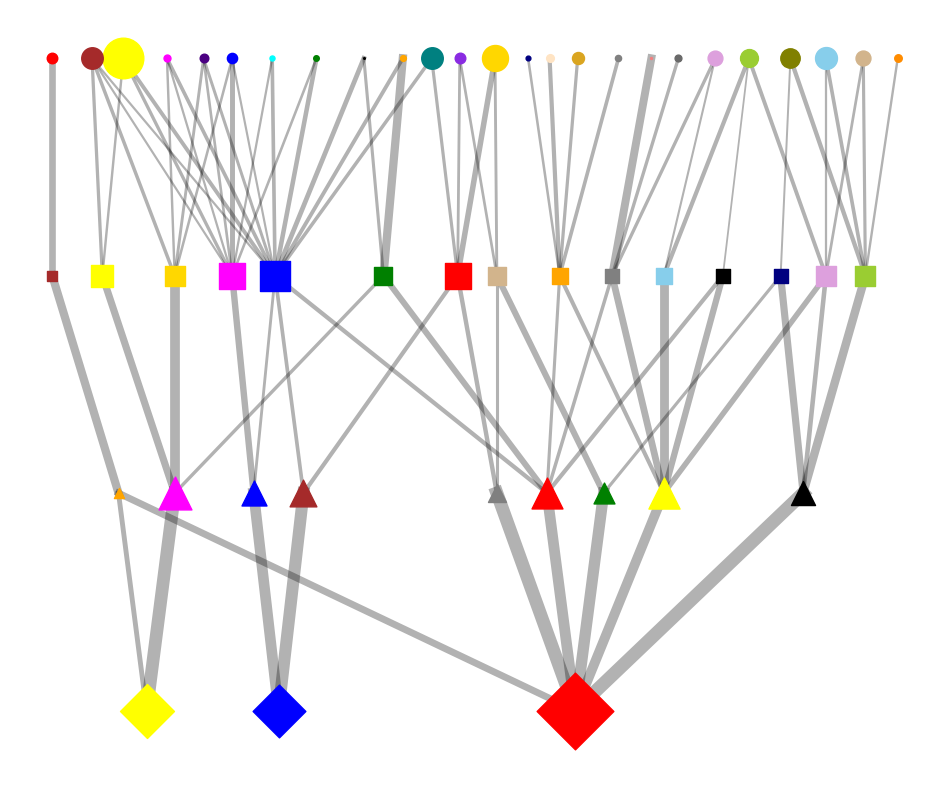

In [41]:
#Build summarized graph for all the tissues and donors
comm_graph1 = graph_connection(data = cells_network, level_0 = 'Community_test', level_1 = 'Tissue_Unit_test',
                              connection_threshold = 25, level_symbol = ['_m', '_o'])
neighb_graph1 = graph_connection(data = cells_network, level_0 = 'Neighborhood_test', level_1 = 'Community_test',
                              connection_threshold = 20, level_symbol = ['_n', '_m'])
cell_graph1 = graph_connection(data = cells_network, level_0 = 'Cell Type', level_1 = 'Neighborhood_test',
                              connection_threshold = 15, level_symbol = ['_c', '_n'])

level_list = [cell_graph1, neighb_graph1, comm_graph1]
name_list = ['Cell Type','Neighborhood_test','Community_test','Tissue_Unit_test' ]
dict_node_size, dict_shape, dict_weight = build_dict(data_levels=level_list, data_names=name_list)

build_graph(hier_list =level_list, connection_list = name_list, pal_color=pal_color1, dict_node_size=dict_node_size,
            dict_shape=dict_shape, dict_weight=dict_weight, save_path='', save_name='network.png')

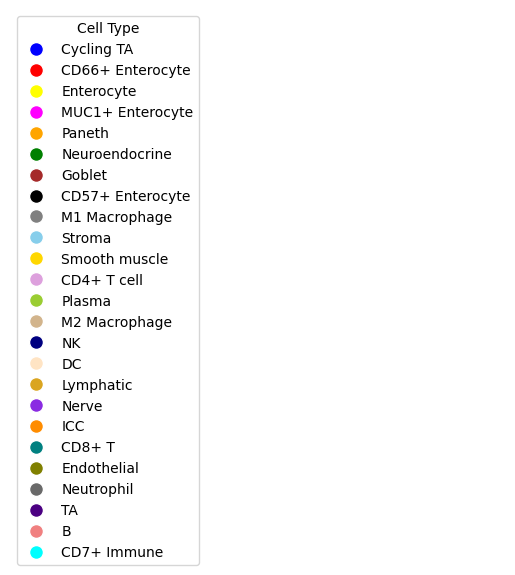

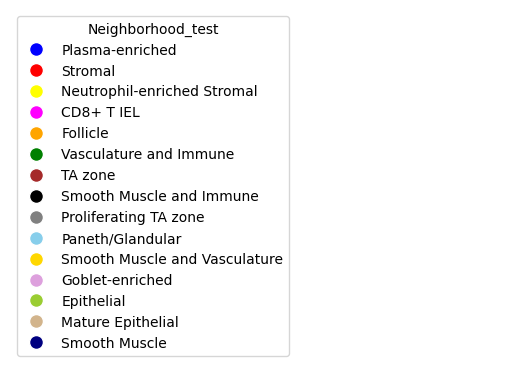

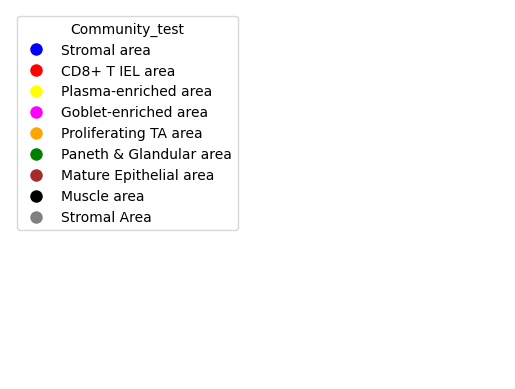

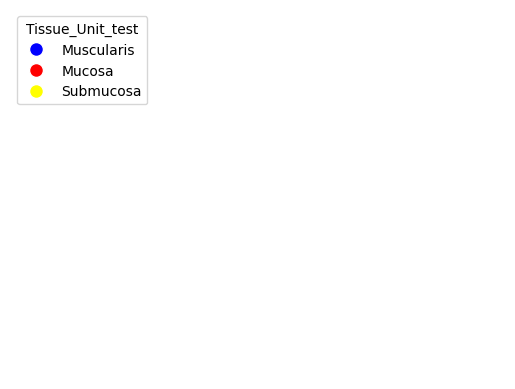

In [42]:
plt.rcParams["legend.markerscale"] = 1
legend_list = [cell_map, neigh_map, comm_map, tissue_map]
Name_list = ['Cell Type','Neighborhood_test','Community_test','Tissue_Unit_test' ]

for diction, categ in zip(legend_list, Name_list):
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cell_type, markerfacecolor=color, markersize=10)
                  for cell_type, color in diction.items()]

    plt.figure()
    plt.legend(handles=legend_elements, title=categ, loc='upper left')
    plt.axis('off')  # Turn off the axis for the legend
    plt.savefig(categ+'_'+'_hierarcy_map.png', format='png', dpi=300, transparent=True, bbox_inches='tight')
    plt.show()